In [125]:
import numpy as np
import pandas as pd

In [126]:
df = pd.read_csv("/content/AswanData_weatherdata.csv")

# Weather Dataset Project — Solar(PV) Classification

**Dataset:** `AswanData_weatherdata.csv`  
**Goal:** Create a classification target from `Solar(PV)` (Low / Medium / High) and perform full preprocessing, EDA, feature-reduction (PCA, LDA), multiple classifiers (Naive Bayes, Bayesian Network if available, Decision Tree, LDA classifier, PCA+KNN, KNN with different distances), and evaluation (confusion matrix, accuracy, precision, recall, F1, ROC).



In [127]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, classification_report)
from sklearn.pipeline import Pipeline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Attempt to import pgmpy for Bayesian Network (may not be installed)
have_pgmpy = False
try:
    import pgmpy
    from pgmpy.estimators import HillClimbSearch, BicScore
    from pgmpy.models import BayesianModel
    have_pgmpy = True
except Exception as e:
    have_pgmpy = False

print('pgmpy available:', have_pgmpy)

# Plot settings
%matplotlib inline
sns.set(style='whitegrid')


pgmpy available: False


# **1 - Data Pre-Processing**

In [128]:
#Dataset size : (rows, columns)
print('Shape:', df.shape)

Shape: (398, 8)


In [129]:
#First 5 rows
df.head()

,Unnamed: 0,Date,AvgTemperture,AverageDew(point via humidity),Humidity,Wind,Pressure,Solar(PV)
0,0,4/1/2022,87.9,31.3,13.4,5.7,29.2,19.010857
1,2,4/3/2022,90.2,34.0,14.2,6.6,29.1,16.885714
2,3,4/4/2022,93.2,31.4,11.8,8.8,29.1,19.627429
3,4,4/5/2022,92.5,24.9,9.4,8.0,29.1,18.929429
4,5,4/6/2022,91.2,18.9,7.8,9.4,29.2,18.934000


In [130]:
# Quick column cleaning
df.columns = [c.strip().replace('\n',' ').replace('  ',' ') for c in df.columns]

# Friendly rename map (adjust if your dataset differs)
rename_map = {
    'AvgTemperture':'AvgTemperature',
    'AverageDew(point via humidity)':'AverageDew',
    'Solar(PV)':'Solar_PV'
}
df.rename(columns=rename_map, inplace=True)

# Parse Date column if exists
if 'Date' in df.columns:
    try:
        df['Date'] = pd.to_datetime(df['Date'])
    except Exception:
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=False, errors='coerce')

# Drop unnamed index-like column if present
for c in df.columns:
    if str(c).lower().startswith('unnamed'):
        df.drop(columns=[c], inplace=True)

print('After rename and cleanup — columns:')
print(df.columns.tolist())
df.head()


After rename and cleanup — columns:
['Date', 'AvgTemperature', 'AverageDew', 'Humidity', 'Wind', 'Pressure', 'Solar_PV']


,Date,AvgTemperature,AverageDew,Humidity,Wind,Pressure,Solar_PV
0,2022-04-01,87.9,31.3,13.4,5.7,29.2,19.010857
1,2022-04-03,90.2,34.0,14.2,6.6,29.1,16.885714
2,2022-04-04,93.2,31.4,11.8,8.8,29.1,19.627429
3,2022-04-05,92.5,24.9,9.4,8.0,29.1,18.929429
4,2022-04-06,91.2,18.9,7.8,9.4,29.2,18.934000


In [131]:
# Missing values
missing = df.isnull().sum()
print("Missing values (non-zero):")
print(missing[missing>0])

# Drop duplicate rows if any
dup_count = df.duplicated().sum()
print('Duplicate rows:', dup_count)
if dup_count>0:
    df = df.drop_duplicates()

# Basic stats
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', num_cols)
df[num_cols].describe().T


Missing values (non-zero):
Series([], dtype: int64)
Duplicate rows: 28
Numeric columns: ['AvgTemperature', 'AverageDew', 'Humidity', 'Wind', 'Pressure', 'Solar_PV']


,count,mean,std,min,25%,50%,75%,max
AvgTemperature,370.0,81.405676,13.961259,51.100000,69.725000,84.250000,93.9000,102.700000
AverageDew,370.0,37.460811,8.749325,15.300000,30.400000,38.200000,44.3000,63.900000
Humidity,370.0,23.753784,9.641380,7.400000,16.325000,21.200000,29.6000,47.700000
Wind,370.0,10.314865,2.454501,4.400000,8.500000,10.300000,12.1750,17.100000
Pressure,370.0,29.190135,0.141962,28.900000,29.100000,29.200000,29.3000,29.600000
Solar_PV,370.0,24.800943,7.598311,8.581429,18.038214,24.368714,32.2165,40.038857


**Binning**

In [132]:
# Ensure Solar_PV exists
if 'Solar_PV' not in df.columns:
    raise ValueError('Solar_PV column not found — check your dataset column names')

# Use quantiles to define bins
q33 = df['Solar_PV'].quantile(0.33)
q66 = df['Solar_PV'].quantile(0.66)
print("33rd percentile:", q33, "66th percentile:", q66)

# Create labels
labels = ['Low', 'Medium', 'High']
df['Solar_cat'] = pd.cut(df['Solar_PV'], bins=[-np.inf, q33, q66, np.inf], labels=labels)

# Show counts
print(df['Solar_cat'].value_counts())


33rd percentile: 19.7108 66th percentile: 30.1755657166
Solar_cat
High      126
Low       122
Medium    122
Name: count, dtype: int64


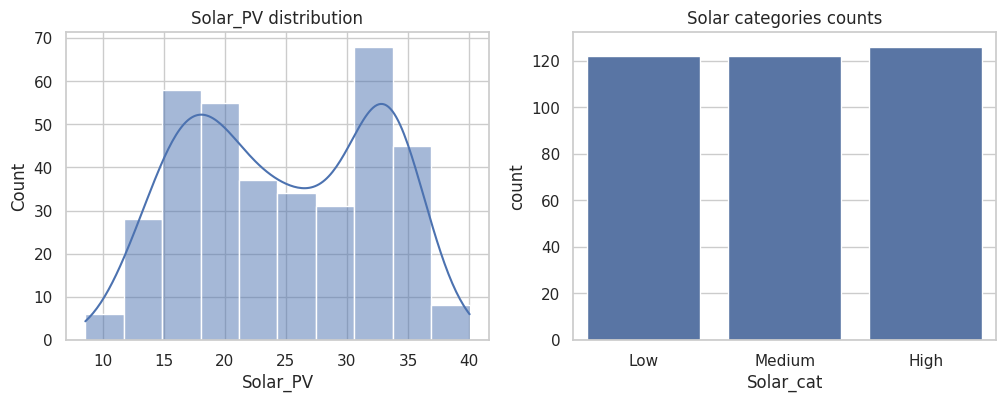

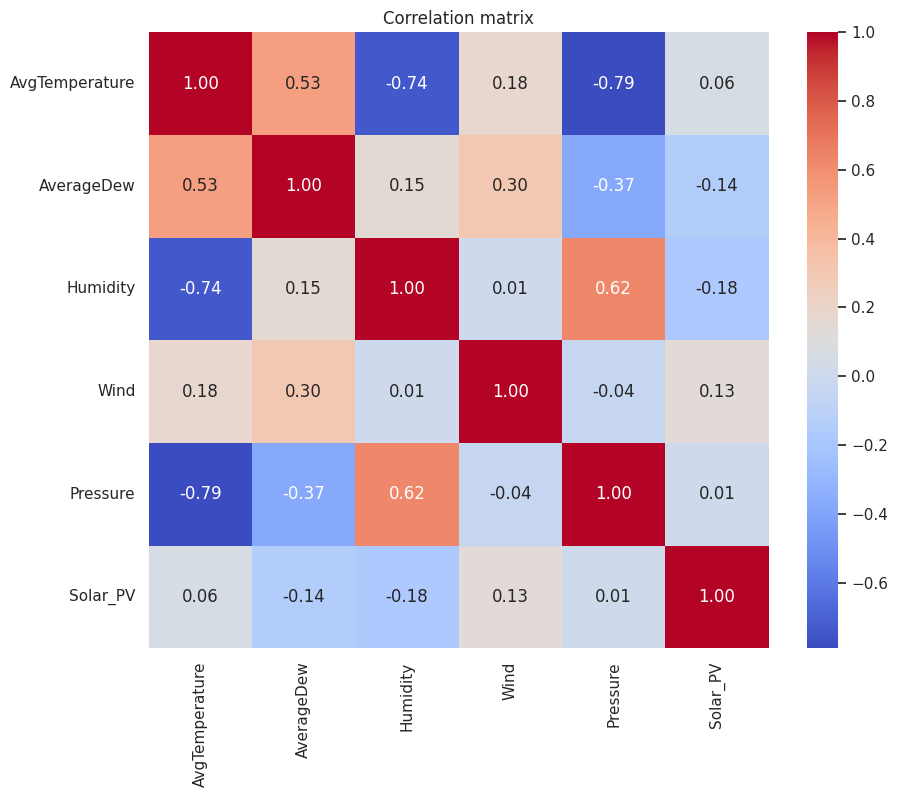

In [133]:
# Histogram of Solar_PV and counts for categories
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['Solar_PV'].dropna(), kde=True)
plt.title('Solar_PV distribution')

plt.subplot(1,2,2)
sns.countplot(x='Solar_cat', data=df, order=labels)
plt.title('Solar categories counts')
plt.show()

# Pairwise correlation heatmap for numeric features
plt.figure(figsize=(10,8))
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cor = df[num_cols].corr()
sns.heatmap(cor, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()


In [134]:
from scipy.stats import skew, kurtosis
stats_df = pd.DataFrame(index=num_cols, columns=['mean','min','max','var','std','skew','kurtosis'])
for c in num_cols:
    stats_df.loc[c,'mean'] = df[c].mean()
    stats_df.loc[c,'min'] = df[c].min()
    stats_df.loc[c,'max'] = df[c].max()
    stats_df.loc[c,'var'] = df[c].var()
    stats_df.loc[c,'std'] = df[c].std()
    stats_df.loc[c,'skew'] = skew(df[c].dropna())
    stats_df.loc[c,'kurtosis'] = kurtosis(df[c].dropna())

stats_df = stats_df.astype(float).round(4)
stats_df
# Covariance matrix
cov = df[num_cols].cov()
cov.round(4)


,AvgTemperature,AverageDew,Humidity,Wind,Pressure,Solar_PV
AvgTemperature,194.9167,64.5199,-99.3934,6.1196,-1.5681,6.6095
AverageDew,64.5199,76.5507,12.6015,6.5159,-0.4631,-9.5475
Humidity,-99.3934,12.6015,92.9562,0.3014,0.8553,-13.1574
Wind,6.1196,6.5159,0.3014,6.0246,-0.0139,2.5111
Pressure,-1.5681,-0.4631,0.8553,-0.0139,0.0202,0.0085
Solar_PV,6.6095,-9.5475,-13.1574,2.5111,0.0085,57.7343


DESCRIPTIVE STATISTICS
      Variable       Min        Max      Mean    Median   Variance   Std Dev  Skewness  Kurtosis
AvgTemperature 51.100000 102.700000 81.405676 84.250000 194.916743 13.961259 -0.446762 -1.035201
    AverageDew 15.300000  63.900000 37.460811 38.200000  76.550682  8.749325 -0.076617 -0.596802
      Humidity  7.400000  47.700000 23.753784 21.200000  92.956205  9.641380  0.685844 -0.493652
          Wind  4.400000  17.100000 10.314865 10.300000   6.024575  2.454501  0.229787 -0.118741
      Pressure 28.900000  29.600000 29.190135 29.200000   0.020153  0.141962  0.364823 -0.721573
      Solar_PV  8.581429  40.038857 24.800943 24.368714  57.734326  7.598311 -0.013730 -1.300666


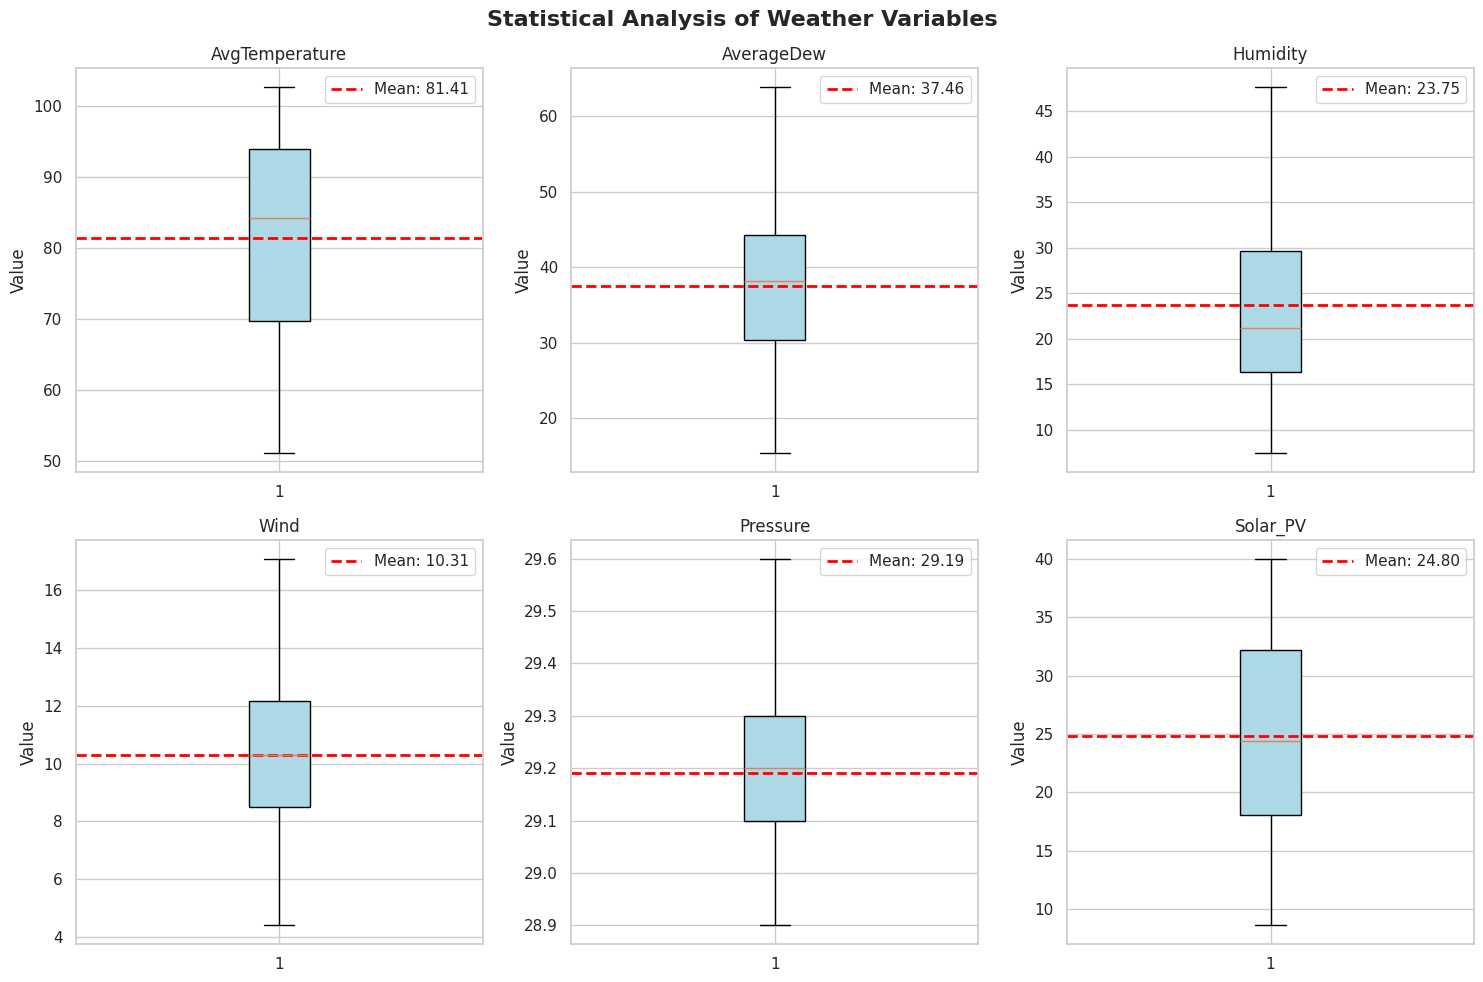

In [135]:
# ## 6. Data Analysis - Descriptive Statistics

# -%
print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)

# Select numerical columns for analysis
numerical_cols = ['AvgTemperature', 'AverageDew',
                  'Humidity', 'Wind', 'Pressure', 'Solar_PV']

# Create comprehensive statistics table
stats_dict = {
    'Variable': [],
    'Min': [],
    'Max': [],
    'Mean': [],
    'Median': [],
    'Variance': [],
    'Std Dev': [],
    'Skewness': [],
    'Kurtosis': []
}

for col in numerical_cols:
    stats_dict['Variable'].append(col)
    stats_dict['Min'].append(df[col].min())
    stats_dict['Max'].append(df[col].max())
    stats_dict['Mean'].append(df[col].mean())
    stats_dict['Median'].append(df[col].median())
    stats_dict['Variance'].append(df[col].var())
    stats_dict['Std Dev'].append(df[col].std())
    stats_dict['Skewness'].append(df[col].skew())
    stats_dict['Kurtosis'].append(df[col].kurtosis())

stats_df = pd.DataFrame(stats_dict)
print(stats_df.to_string(index=False))

# Visual representation of statistics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Statistical Analysis of Weather Variables', fontsize=16, fontweight='bold')

for idx, col in enumerate(numerical_cols):
    ax = axes[idx//3, idx%3]

    # Box plot
    bp = ax.boxplot(df[col], vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')

    # Add mean line
    ax.axhline(y=df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.2f}')

    ax.set_title(col)
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

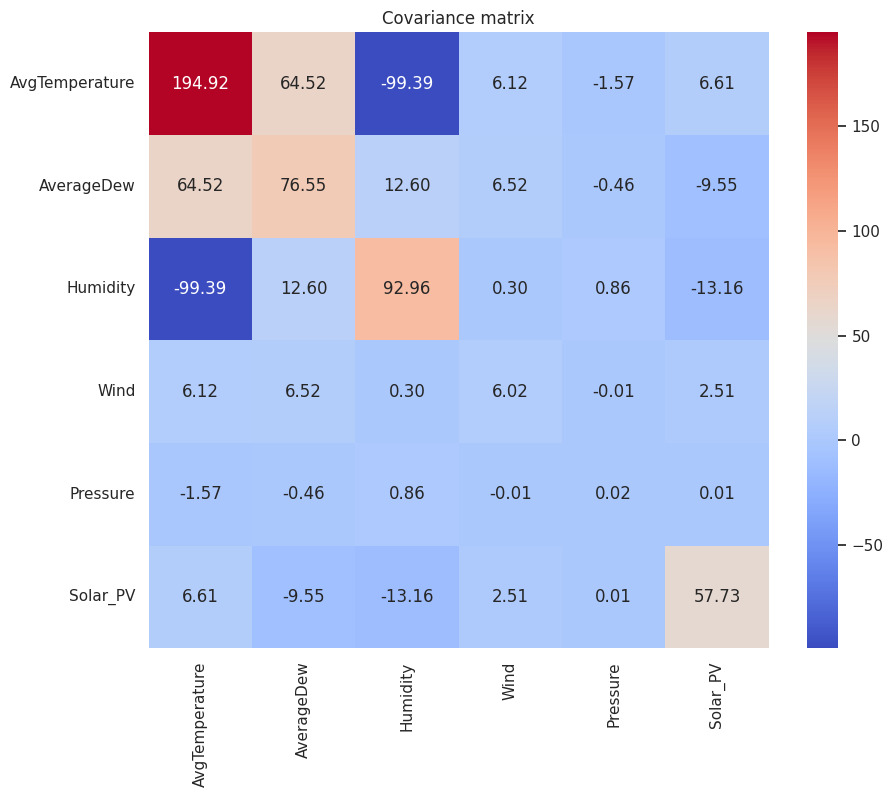

In [136]:
plt.figure(figsize=(10,8))
sns.heatmap(cov, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Covariance matrix')
plt.show()

In [137]:
# Create month column if Date present
if 'Date' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Month'] = df['Date'].dt.month
else:
    df['Month'] = pd.to_datetime(df['Date'], errors='coerce').dt.month

# Chi-square test between Solar_cat and Month (categorical)
cont = pd.crosstab(df['Solar_cat'], df['Month'])
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(cont.fillna(0))
print('Chi-square test between Solar category and Month: chi2=%.3f, p=%.5f' % (chi2,p))

# ANOVA: does Solar_PV differ by Month?
anova_p = None
try:
    groups = [g['Solar_PV'].dropna().values for n,g in df.groupby('Month') if len(g['Solar_PV'].dropna())>0]
    if len(groups) >= 2:
        fstat, anova_p = stats.f_oneway(*groups)
        print('ANOVA across months: F=%.3f, p=%.5f' % (fstat, anova_p))
    else:
        print('Not enough month groups for ANOVA.')
except Exception as e:
    print('ANOVA failed:', e)

# t-test example between Low and High Solar_PV groups
low_vals = df[df['Solar_cat']=='Low']['Solar_PV'].dropna()
high_vals = df[df['Solar_cat']=='High']['Solar_PV'].dropna()
if len(low_vals)>1 and len(high_vals)>1:
    tstat, tp = stats.ttest_ind(low_vals, high_vals, equal_var=False, nan_policy='omit')
    print('t-test Low vs High Solar_PV: t=%.3f, p=%.5f' % (tstat, tp))
else:
    print('Not enough samples for Low vs High t-test.')


Chi-square test between Solar category and Month: chi2=341.649, p=0.00000
ANOVA across months: F=70.392, p=0.00000
t-test Low vs High Solar_PV: t=-61.942, p=0.00000


#Generate a stacked bar chart or a grouped bar chart to show the distribution of 'Solar_cat' (Low, Medium, High) across different months. This visualization will help understand the categorical relationship that the ***chi-square*** test analyzed. Ensure clear labels and a legend.

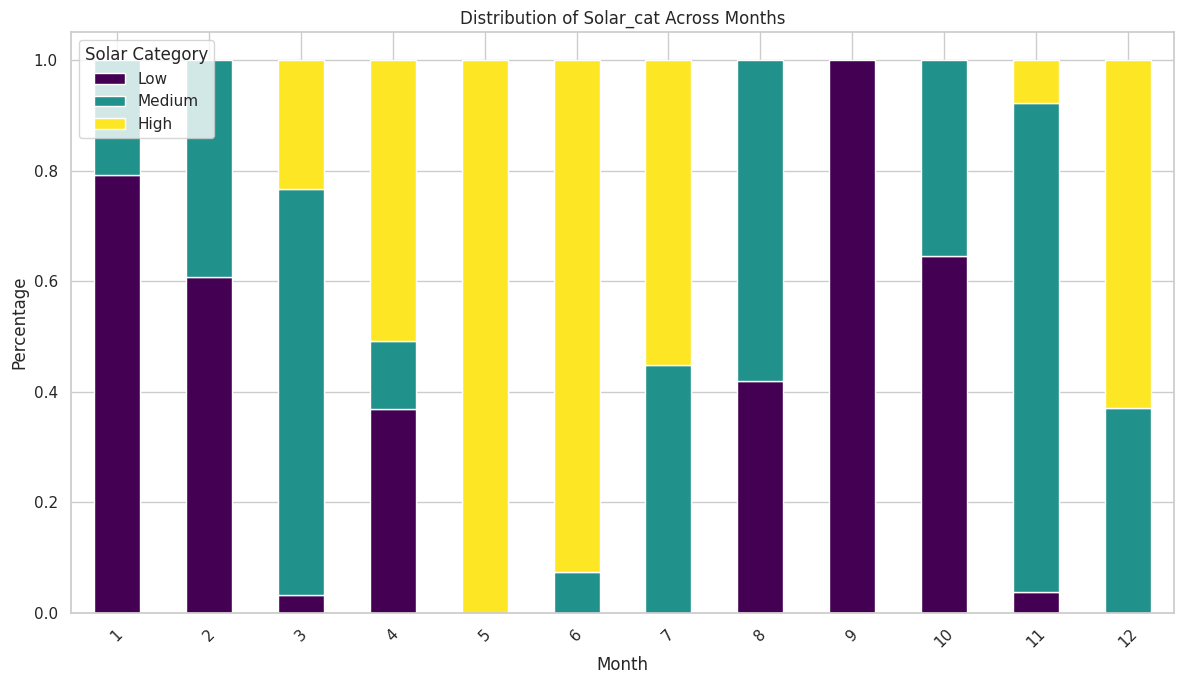

In [138]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create a cross-tabulation of 'Month' and 'Solar_cat'
crosstab_df = pd.crosstab(df['Month'], df['Solar_cat'])

# 2. Normalize the cross-tabulation to show percentages within each month
crosstab_norm = crosstab_df.div(crosstab_df.sum(1), axis=0)

# 3. Plot a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 7))
crosstab_norm.plot.bar(stacked=True, ax=ax, cmap='viridis')
ax.set_title('Distribution of Solar_cat Across Months')
ax.set_xlabel('Month')
ax.set_ylabel('Percentage')
ax.legend(title='Solar Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Create a box plot or violin plot to visualize the distribution of 'Solar_PV' for each month. This will illustrate whether there are significant differences in solar photovoltaic energy across months, which was assessed by the ***ANOVA*** test. Ensure clear labels and a legend.

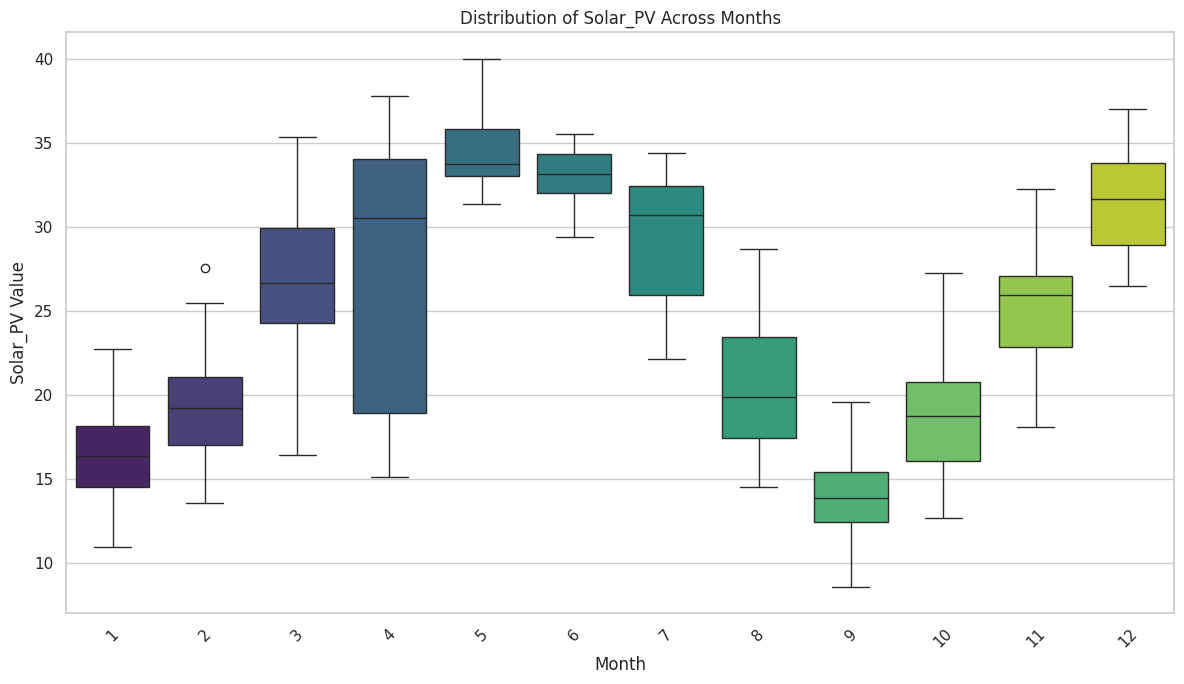

In [139]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Month', y='Solar_PV', data=df, palette='viridis')
plt.title('Distribution of Solar_PV Across Months')
plt.xlabel('Month')
plt.ylabel('Solar_PV Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Generate box plots or violin plots comparing the 'Solar_PV' distributions specifically for the 'Low' and 'High' categories. This visualization will provide a clear picture of the differences between these two groups that the ***t-test*** examined. Ensure clear labels and a legend.

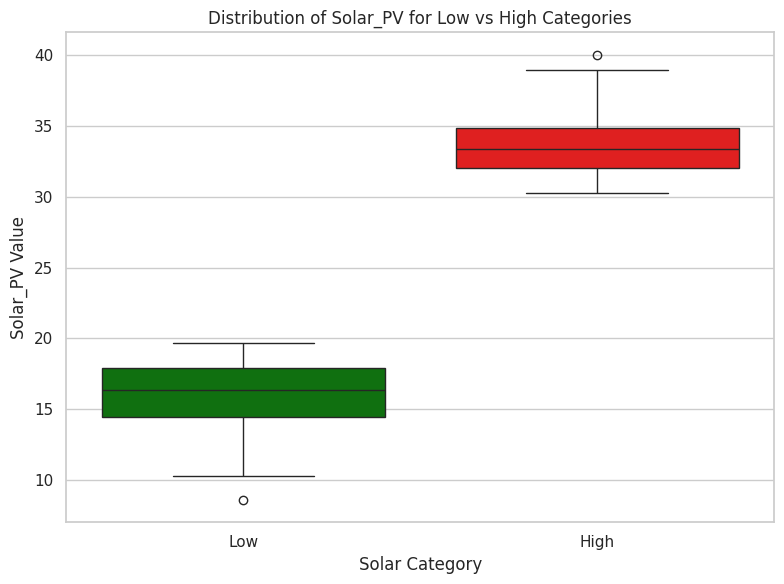

In [140]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Solar_cat', y='Solar_PV', data=df[df['Solar_cat'].isin(['Low', 'High'])], palette=['green', 'red'], order=['Low', 'High'])
plt.title('Distribution of Solar_PV for Low vs High Categories')
plt.xlabel('Solar Category')
plt.ylabel('Solar_PV Value')
plt.tight_layout()
plt.show()

In [141]:
# Select features for modeling — use numeric columns except Solar_PV (target source)
features = [c for c in num_cols if c!='Solar_PV']
print('Features used:', features)

# Drop rows with missing target
df_model = df.dropna(subset=['Solar_cat'])

# Prepare X and y
X = df_model[features].copy()
y = df_model['Solar_cat'].copy()

# If Month is available, include it
if 'Month' in df_model.columns:
    X['Month'] = df_model['Month']

# Fill missing numeric values with median
X = X.fillna(X.median())

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Classes:', le.classes_)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Shapes:', X_train.shape, X_test.shape)


Features used: ['AvgTemperature', 'AverageDew', 'Humidity', 'Wind', 'Pressure']
Classes: ['High' 'Low' 'Medium']
Shapes: (296, 6) (74, 6)


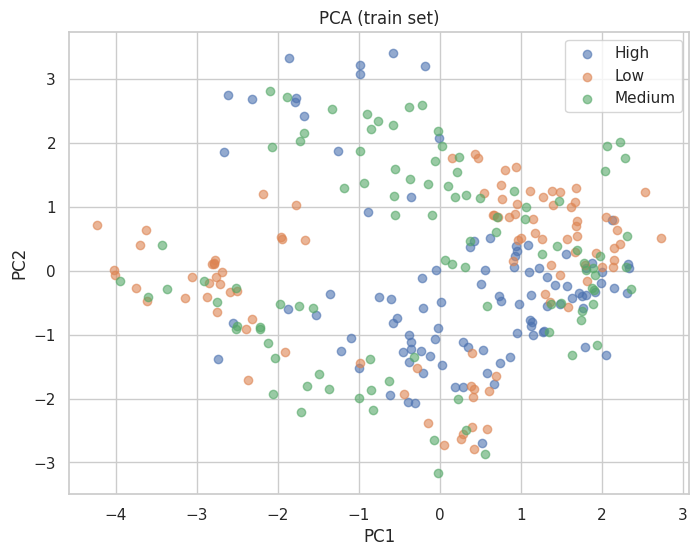

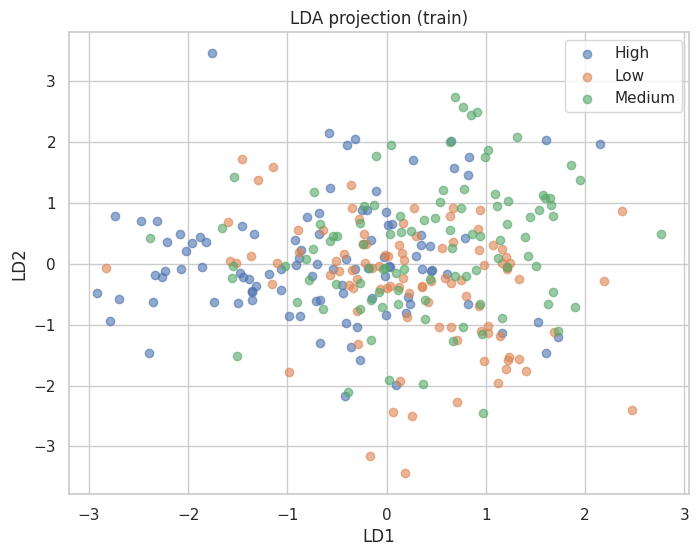

In [142]:
# PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8,6))
for lab in np.unique(y_train):
    plt.scatter(X_pca[y_train==lab,0], X_pca[y_train==lab,1], label=le.inverse_transform([lab])[0], alpha=0.6)
plt.legend(); plt.title('PCA (train set)'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

# LDA projection
lda = LinearDiscriminantAnalysis(n_components=2)
try:
    X_lda = lda.fit_transform(X_train_scaled, y_train)
    plt.figure(figsize=(8,6))
    for lab in np.unique(y_train):
        plt.scatter(X_lda[y_train==lab,0], X_lda[y_train==lab,1], label=le.inverse_transform([lab])[0], alpha=0.6)
    plt.legend(); plt.title('LDA projection (train)'); plt.xlabel('LD1'); plt.ylabel('LD2'); plt.show()
except Exception as e:
    print('LDA projection failed:', e)


In [143]:
from sklearn.model_selection import cross_val_score

def evaluate_model(clf, X_tr, X_te, y_tr, y_te, name='Model'):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    probs = None
    try:
        probs = clf.predict_proba(X_te)
    except Exception:
        pass
    cm = confusion_matrix(y_te, y_pred)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_te, y_pred, average='weighted')
    f1 = f1_score(y_te, y_pred, average='weighted')
    print(f"== {name} ==")
    print('Accuracy: %.4f Precision: %.4f  Recall: %.4f  F1: %.4f' % (acc,prec,rec,f1))
    print('Confusion matrix:\n', cm)
    print('\nClassification report:\n', classification_report(y_te, y_pred, target_names=le.classes_))
    return {'name':name, 'clf':clf, 'y_pred':y_pred, 'probs':probs, 'cm':cm, 'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1}

results = []

# Gaussian Naive Bayes
gnb = GaussianNB()
results.append(evaluate_model(gnb, X_train_scaled, X_test_scaled, y_train, y_test, 'GaussianNB'))

# Decision Tree (entropy)
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
results.append(evaluate_model(dt, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree_entropy'))

# LDA classifier
lda_clf = LinearDiscriminantAnalysis()
results.append(evaluate_model(lda_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'LDA_classifier'))

# KNN variants
knn_euc = KNeighborsClassifier(n_neighbors=5, p=2)  # Euclidean
results.append(evaluate_model(knn_euc, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Euclidean'))
knn_man = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1)  # Manhattan
results.append(evaluate_model(knn_man, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Manhattan'))

# PCA + KNN pipeline
pipe = Pipeline([('pca', PCA(n_components=min(5, X_train_scaled.shape[1]))), ('knn', KNeighborsClassifier(n_neighbors=5))])
results.append(evaluate_model(pipe, X_train_scaled, X_test_scaled, y_train, y_test, 'PCA+KNN'))

# Cross-validated accuracies (5-fold stratified) for each algorithm on full dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_summary = {}
models_for_cv = {'GaussianNB':gnb, 'DecisionTree':dt, 'LDA':lda_clf, 'KNN_Euc':knn_euc}
for name, model in models_for_cv.items():
    try:
        scores = cross_val_score(model, scaler.fit_transform(X), y_enc, cv=cv, scoring='accuracy')
        cv_summary[name] = scores
    except Exception as e:
        cv_summary[name] = np.array([np.nan])

print('\nCross-validation accuracies (5-fold):')
for k,v in cv_summary.items():
    print(k, np.round(v,4), 'mean=', np.round(np.nanmean(v),4))

# Bayesian Network (if available)
if have_pgmpy:
    try:
        from pgmpy.estimators import BicScore, HillClimbSearch
        df_bn = df_model.copy()
        # discretize numeric features into 3 bins for BN learning
        disc = df_bn[num_cols].apply(lambda col: pd.qcut(col, q=3, labels=False, duplicates='drop'))
        df_bn_disc = disc.fillna(0).astype(int)
        hc = HillClimbSearch(df_bn_disc)
        best_model = hc.estimate(scoring_method=BicScore(df_bn_disc))
        print('Learned BayesianModel edges:', best_model.edges())
    except Exception as e:
        print('Bayesian network learning failed:', e)
else:
    print('pgmpy not available — skipping Bayesian network section')


== GaussianNB ==
Accuracy: 0.4459 Precision: 0.4343  Recall: 0.4459  F1: 0.4300
Confusion matrix:
 [[17  4  4]
 [13  6  6]
 [ 6  8 10]]

Classification report:
               precision    recall  f1-score   support

        High       0.47      0.68      0.56        25
         Low       0.33      0.24      0.28        25
      Medium       0.50      0.42      0.45        24

    accuracy                           0.45        74
   macro avg       0.44      0.45      0.43        74
weighted avg       0.43      0.45      0.43        74

== DecisionTree_entropy ==
Accuracy: 0.6757 Precision: 0.6967  Recall: 0.6757  F1: 0.6775
Confusion matrix:
 [[17  1  7]
 [ 2 20  3]
 [ 0 11 13]]

Classification report:
               precision    recall  f1-score   support

        High       0.89      0.68      0.77        25
         Low       0.62      0.80      0.70        25
      Medium       0.57      0.54      0.55        24

    accuracy                           0.68        74
   macro avg   

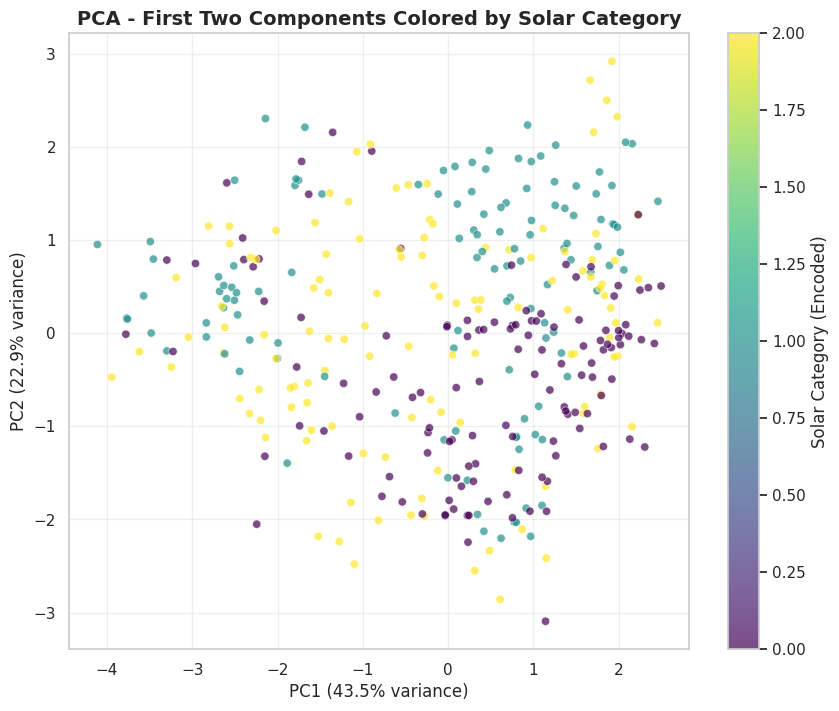

In [144]:
# Select top 2 components for visualization
pca_2d_classes = PCA(n_components=2)
X_pca_2d_classes = pca_2d_classes.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d_classes[:, 0], X_pca_2d_classes[:, 1],
                      c=y_encoded, cmap='viridis', alpha=0.7, edgecolors='w', linewidth=0.5)
plt.colorbar(scatter, label='Solar Category (Encoded)')
plt.xlabel(f'PC1 ({pca_2d_classes.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca_2d_classes.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('PCA - First Two Components Colored by Solar Category', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

In [145]:
print('Model Error Rates:')
for res in results:
    error_rate = 1 - res['acc']
    print(f"{res['name']}: {error_rate:.4f}")

Model Error Rates:
GaussianNB: 0.5541
DecisionTree_entropy: 0.3243
LDA_classifier: 0.5946
KNN_Euclidean: 0.3243
KNN_Manhattan: 0.3243
PCA+KNN: 0.3243


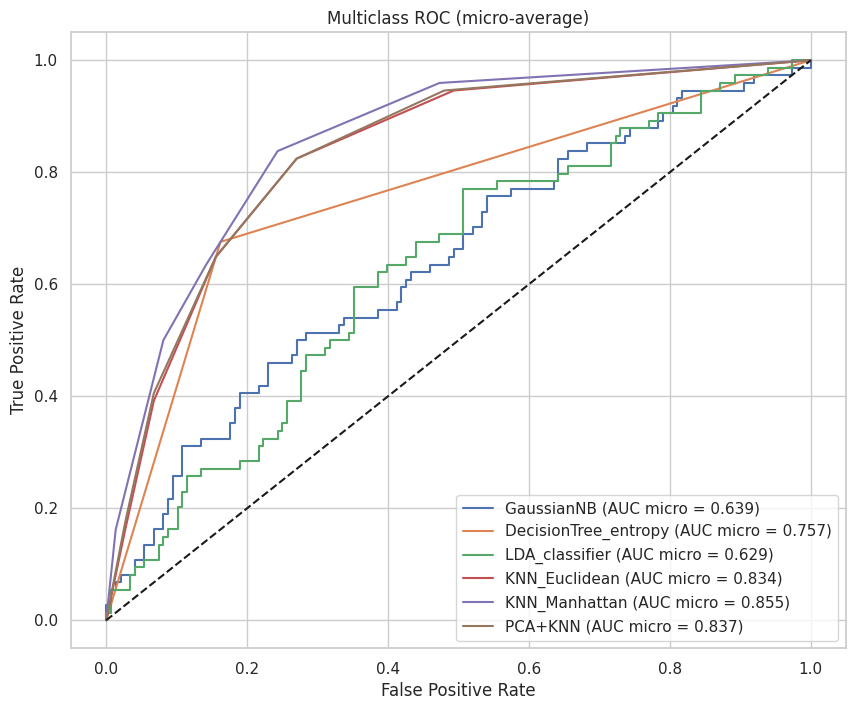

Note: Some classifiers may not implement predict_proba — those are skipped from ROC plotting.


In [146]:
from sklearn.preprocessing import label_binarize
n_classes = len(le.classes_)

y_test_b = label_binarize(y_test, classes=list(range(n_classes)))

plt.figure(figsize=(10,8))
for res in results:
    name = res['name']
    probs = res['probs']
    if probs is None:
        continue
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), probs.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
    plt.plot(fpr['micro'], tpr['micro'], label=f"{name} (AUC micro = {roc_auc['micro']:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC (micro-average)')
plt.legend(); plt.show()

print('Note: Some classifiers may not implement predict_proba — those are skipped from ROC plotting.')


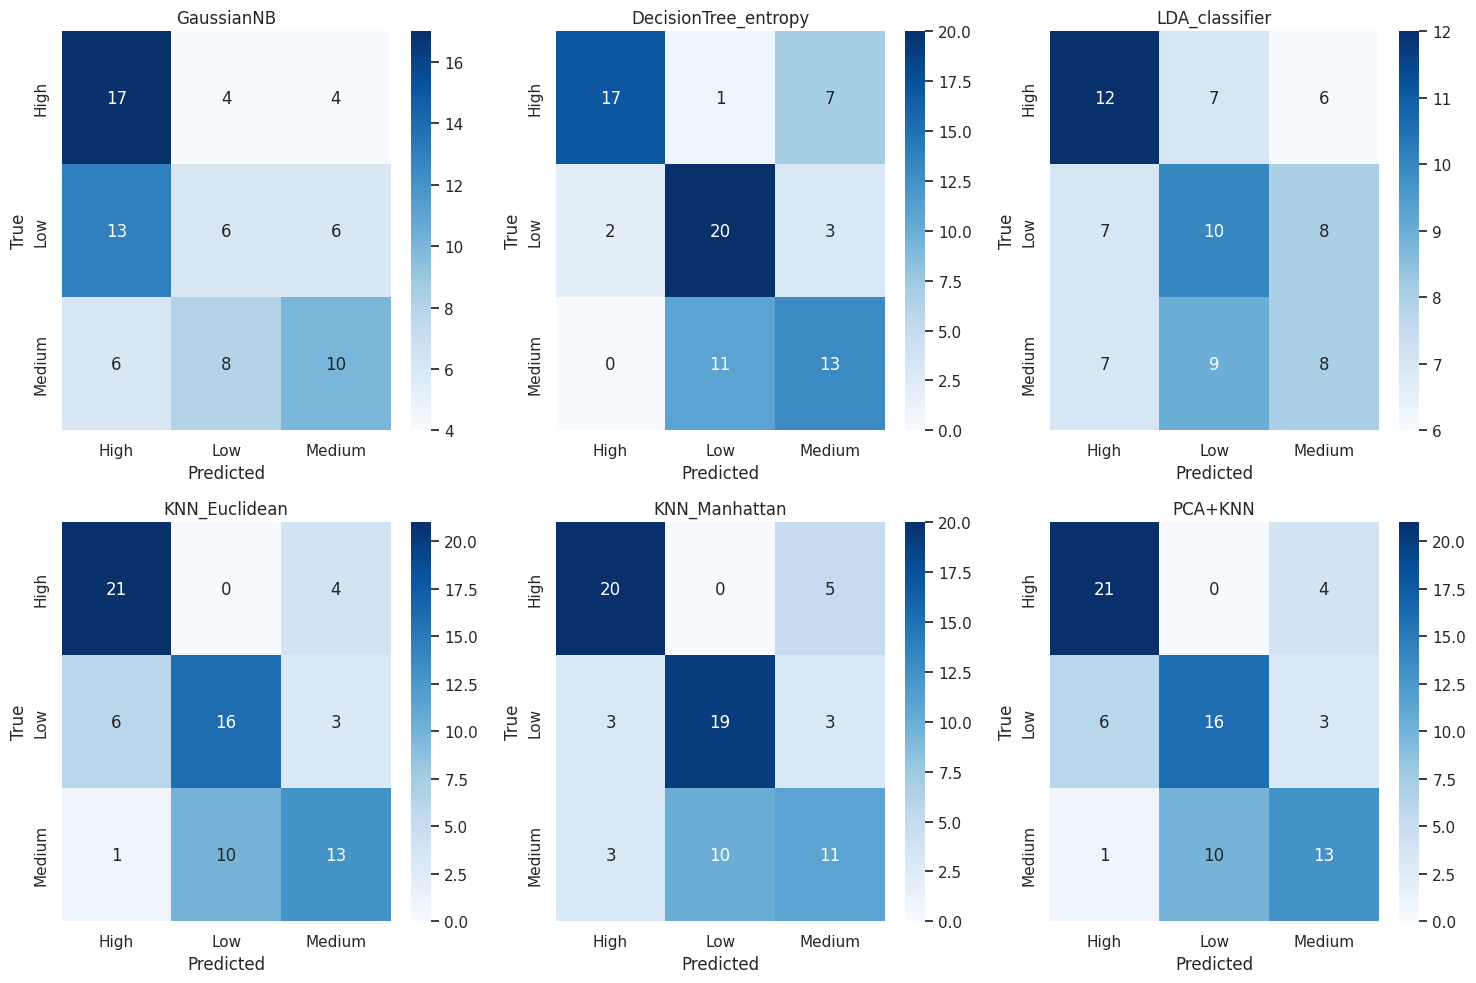

In [147]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes = axes.ravel()
for ax, res in zip(axes, results):
    cm = res['cm']
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(res['name'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_xticklabels(le.classes_); ax.set_yticklabels(le.classes_)
# Hide any unused subplots
for i in range(len(results), len(axes)):
    axes[i].axis('off')
plt.tight_layout(); plt.show()


In [148]:
print('Model Accuracies:')
for res in results:
    print(f"{res['name']}: {res['acc']:.4f}")

Model Accuracies:
GaussianNB: 0.4459
DecisionTree_entropy: 0.6757
LDA_classifier: 0.4054
KNN_Euclidean: 0.6757
KNN_Manhattan: 0.6757
PCA+KNN: 0.6757


In [149]:
def model_fit_status(clf, X_train, X_test, y_train, y_test, name="model"):
    # predictions
    train_pred = clf.predict(X_train)
    test_pred  = clf.predict(X_test)

    # accuracies
    train_acc = accuracy_score(y_train, train_pred)
    test_acc  = accuracy_score(y_test, test_pred)

    # thresholds
    diff = train_acc - test_acc

    print(f"\n {name}")
    print(f"Train Accuracy: {train_acc:.3f}")
    print(f"Test Accuracy : {test_acc:.3f}")
    print(f"Diff (Train-Test) = {diff:.3f}")

    # conditions
    if train_acc > 0.90 and diff > 0.15:
        print(" Model is **Overfitted** ")
    elif train_acc < 0.70 and test_acc < 0.70:
        print(" Model is **Underfitted** ")
    else:
        print(" Model is **Well-fitted / Balanced** ")

    return train_acc, test_acc


In [150]:
model_fit_status(gnb, X_train_scaled, X_test_scaled, y_train, y_test, "GaussianNB")
model_fit_status(dt, X_train_scaled, X_test_scaled, y_train, y_test, "DecisionTree")
model_fit_status(lda_clf, X_train_scaled, X_test_scaled, y_train, y_test, "LDA")
model_fit_status(knn_euc, X_train_scaled, X_test_scaled, y_train, y_test, "KNN_Euclidean")
model_fit_status(knn_man, X_train_scaled, X_test_scaled, y_train, y_test, "KNN_Manhattan")
model_fit_status(pipe, X_train_scaled, X_test_scaled, y_train, y_test, "PCA+KNN")



 GaussianNB
Train Accuracy: 0.527
Test Accuracy : 0.446
Diff (Train-Test) = 0.081
 Model is **Underfitted** 

 DecisionTree
Train Accuracy: 1.000
Test Accuracy : 0.676
Diff (Train-Test) = 0.324
 Model is **Overfitted** 

 LDA
Train Accuracy: 0.490
Test Accuracy : 0.405
Diff (Train-Test) = 0.084
 Model is **Underfitted** 

 KNN_Euclidean
Train Accuracy: 0.743
Test Accuracy : 0.676
Diff (Train-Test) = 0.068
 Model is **Well-fitted / Balanced** 

 KNN_Manhattan
Train Accuracy: 0.777
Test Accuracy : 0.676
Diff (Train-Test) = 0.101
 Model is **Well-fitted / Balanced** 

 PCA+KNN
Train Accuracy: 0.743
Test Accuracy : 0.676
Diff (Train-Test) = 0.068
 Model is **Well-fitted / Balanced** 


(0.7432432432432432, 0.6756756756756757)

In [151]:
dt_tuned = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=7)
results.append(evaluate_model(dt_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree_tuned'))
model_fit_status(dt_tuned, X_train_scaled, X_test_scaled, y_train, y_test, "DecisionTree_tuned")

# Update models_for_cv for cross-validation
models_for_cv['DecisionTree'] = dt_tuned


== DecisionTree_tuned ==
Accuracy: 0.6892 Precision: 0.7018  Recall: 0.6892  F1: 0.6775
Confusion matrix:
 [[19  1  5]
 [ 3 22  0]
 [ 1 13 10]]

Classification report:
               precision    recall  f1-score   support

        High       0.83      0.76      0.79        25
         Low       0.61      0.88      0.72        25
      Medium       0.67      0.42      0.51        24

    accuracy                           0.69        74
   macro avg       0.70      0.69      0.68        74
weighted avg       0.70      0.69      0.68        74


 DecisionTree_tuned
Train Accuracy: 0.922
Test Accuracy : 0.689
Diff (Train-Test) = 0.233
 Model is **Overfitted** 


In [152]:
print('Re-evaluating all models with updated Decision Tree...')

# Clear previous results to avoid duplicates
results = []

# Gaussian Naive Bayes
gnb = GaussianNB()
results.append(evaluate_model(gnb, X_train_scaled, X_test_scaled, y_train, y_test, 'GaussianNB'))

# Decision Tree (tuned)
dt = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=7) # Re-initialize with tuned parameters
results.append(evaluate_model(dt, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree_tuned'))

# LDA classifier
lda_clf = LinearDiscriminantAnalysis()
results.append(evaluate_model(lda_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'LDA_classifier'))

# KNN variants
knn_euc = KNeighborsClassifier(n_neighbors=5, p=2)  # Euclidean
results.append(evaluate_model(knn_euc, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Euclidean'))
knn_man = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1)  # Manhattan
results.append(evaluate_model(knn_man, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Manhattan'))

# PCA + KNN pipeline
pipe = Pipeline([('pca', PCA(n_components=min(5, X_train_scaled.shape[1]))), ('knn', KNeighborsClassifier(n_neighbors=5))])
results.append(evaluate_model(pipe, X_train_scaled, X_test_scaled, y_train, y_test, 'PCA+KNN'))

print('\n--- Fit Status for all models ---\n')
fit_statuses = []
for res in results:
    name = res['name']
    clf = res['clf']
    train_acc, test_acc = model_fit_status(clf, X_train_scaled, X_test_scaled, y_train, y_test, name)
    fit_statuses.append({'Model': name, 'Train Accuracy': f'{train_acc:.3f}', 'Test Accuracy': f'{test_acc:.3f}', 'Diff (Train-Test)': f'{train_acc-test_acc:.3f}'})

# Update models_for_cv for cross-validation again if needed (ensure it has the tuned DT)
models_for_cv = {
    'GaussianNB': gnb,
    'DecisionTree': dt, # Tuned Decision Tree
    'LDA': lda_clf,
    'KNN_Euc': knn_euc
}

# Re-run cross-validation (5-fold stratified) for each algorithm on full dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_summary = {}
for name, model in models_for_cv.items():
    try:
        # Ensure the scaler is fitted to the full dataset X
        X_full_scaled = scaler.fit_transform(X)
        scores = cross_val_score(model, X_full_scaled, y_enc, cv=cv, scoring='accuracy')
        cv_summary[name] = scores
    except Exception as e:
        cv_summary[name] = np.array([np.nan])

print('\nCross-validation accuracies (5-fold):')
for k,v in cv_summary.items():
    print(k, np.round(v,4), 'mean=', np.round(np.nanmean(v),4))

Re-evaluating all models with updated Decision Tree...
== GaussianNB ==
Accuracy: 0.4459 Precision: 0.4343  Recall: 0.4459  F1: 0.4300
Confusion matrix:
 [[17  4  4]
 [13  6  6]
 [ 6  8 10]]

Classification report:
               precision    recall  f1-score   support

        High       0.47      0.68      0.56        25
         Low       0.33      0.24      0.28        25
      Medium       0.50      0.42      0.45        24

    accuracy                           0.45        74
   macro avg       0.44      0.45      0.43        74
weighted avg       0.43      0.45      0.43        74

== DecisionTree_tuned ==
Accuracy: 0.6892 Precision: 0.7018  Recall: 0.6892  F1: 0.6775
Confusion matrix:
 [[19  1  5]
 [ 3 22  0]
 [ 1 13 10]]

Classification report:
               precision    recall  f1-score   support

        High       0.83      0.76      0.79        25
         Low       0.61      0.88      0.72        25
      Medium       0.67      0.42      0.51        24

    accuracy    

In [153]:
print('Model Error Rates:')
for res in results:
    error_rate = 1 - res['acc']
    print(f"{res['name']}: {error_rate:.4f}")

Model Error Rates:
GaussianNB: 0.5541
DecisionTree_tuned: 0.3108
LDA_classifier: 0.5946
KNN_Euclidean: 0.3243
KNN_Manhattan: 0.3243
PCA+KNN: 0.3243


In [154]:
print('\nCross-validation accuracies (5-fold):')
for k,v in cv_summary.items():
    print(f"{k}: {np.round(v,4).tolist()} mean= {np.round(np.nanmean(v),4)}")


Cross-validation accuracies (5-fold):
GaussianNB: [0.5405, 0.3378, 0.5811, 0.4189, 0.4324] mean= 0.4622
DecisionTree: [0.8378, 0.5811, 0.7973, 0.7162, 0.6486] mean= 0.7162
LDA: [0.5405, 0.3649, 0.5405, 0.5135, 0.3784] mean= 0.4676
KNN_Euc: [0.6622, 0.527, 0.7432, 0.6622, 0.6351] mean= 0.6459
